In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math, os, random, time
from typing import Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from datetime import timedelta

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP    = torch.cuda.is_available()

print(f'Device: {device} | AMP: {AMP}')


CFG = dict(
    csv_path   = '../data/data.csv',
    target_col  = "load_mw",
    save_name   = "../checkpoints/aedl_quant.pt",  # where to save the model weights

    # ------------- model / trainer settings -------------
    past_len    = 48,  
    pred_len    = 24,     
    batch_size  = 256,
    hidden_size = 128,
    num_layers  = 2,
    attn_heads  = 8,
    dropout     = 0.1,
    lr          = 2e-4,
    epochs      = 100,
    es_patience  = 30,
    train_pct   = 0.8,
    val_pct     = 0.2,
    # specific settings quant forecast
    warmup_steps        = 300,
    weight_decay        = 1e-2,
    grad_clip           = 1.0,
    quantiles           = [0.1,0.5,0.9],
    lambda_max          = 5e-3,

    #  exogenous vars
    weather_cols = [
        "temperature",
        "dewpoint",
        "pressure_nn",
        "windspeed",
    ],
    known_future_cols = "temperature_forecast",    

    train_intervals = [("2014-09-02", "2021-12-31 23:00")],
    test_intervals  = [("2022-01-01", "2022-02-28 23:00")],
)


Device: cpu | AMP: False


In [67]:
# 1) read & tidy ----------------------------------------------------
raw_df = (
    pd.read_csv(
        CFG["csv_path"],
        sep=",",
        parse_dates=["MESS_DATUM"],   # <— time stamp column
        dayfirst=False,               # flip if your dates are DD-MM-YYYY
        index_col=0
    )
    .rename(columns=str.lower)        # optional: unify lower-case names
)

# give the timestamp an unmistakable name and make it the index
raw_df = raw_df.rename(columns={"mess_datum": "timestamp"}).set_index("timestamp").sort_index()

# normalize to tz‑naive (UTC wall clock)
raw_df.index = pd.to_datetime(raw_df.index, utc=True).tz_convert('UTC').tz_localize(None)


In [80]:
# ───────────────────── UTILITIES ─────────────────────
def add_time_feats(df):
    dt = df.index
    df = df.copy()
    h = dt.hour + dt.minute/60
    df['h_sin'] = np.sin(2*np.pi*h/24)
    df['h_cos'] = np.cos(2*np.pi*h/24)
    dow = dt.dayofweek
    df['dow_sin'] = np.sin(2*np.pi*dow/7)
    df['dow_cos'] = np.cos(2*np.pi*dow/7)
    df['dow_idx'] = dow.astype(np.int64)
    moy = dt.month - 1
    df['moy_sin'] = np.sin(2*np.pi*moy/12)
    df['moy_cos'] = np.cos(2*np.pi*moy/12)
    df['moy_idx'] = moy.astype(np.int64)
    df['holiday_idx'] = df.get('holiday', 0)
    return df

def evaluate(loader, sy, model):
    model.eval(); maeS=mapeS=sum_y=n=0
    with torch.no_grad():
        for xb,xc,y in loader:
            xb,xc=xb.to(device),xc.to(device); y=y.to(device)
            med = model(xb,xc)[:,:,1]
            yK,medK = inv(y.cpu().numpy(),sy), inv(med.cpu().numpy(),sy)
            maeS+=np.abs(medK-yK).sum()
            mapeS+=(np.abs(medK-yK)/np.clip(np.abs(yK),1e-3,None)).sum()
            sum_y+=yK.sum(); n+=yK.size
    return maeS/n,100*mapeS/n,sum_y/n

def inv(a,sc): return sc.inverse_transform(a.reshape(-1,1)).reshape(a.shape)


def plot_quantile_forecast(sample_idx: int,
                           loader: DataLoader,
                           model: nn.Module,
                           scaler: StandardScaler,
                           quantiles: list[float] = [0.05,0.25,0.75,0.95]):
    """
    Plot the forecast for one sliding-window sample.
    sample_idx : 0-based index into loader.dataset
    quantiles  : list of central quantile endpoints to plot
    """
    # pull the raw indexed data out of the dataset
    ds = loader.dataset
    cont_x, cat_x, y_true_std = ds[sample_idx]
    cont_x = cont_x.unsqueeze(0).to(device)
    cat_x  = cat_x .unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        q_std = model(cont_x, cat_x).cpu().squeeze(0).numpy()  # (pred_len, K)

    # invert scale
    y_true = scaler.inverse_transform(y_true_std.numpy().reshape(-1,1)).ravel()
    q_k     = scaler.inverse_transform(q_std.reshape(-1,1)).reshape(q_std.shape)

    # build time axis: sample 0 starts at test_df.index[past_len]
    # assume you still have `test_df` in scope
    start_time = test_df.index[sample_idx + CFG['past_len']]
    hrs = pd.date_range(start_time, periods=CFG['pred_len'], freq="H")

    plt.figure(figsize=(10,4))
    for q in sorted(quantiles):
        z = norm.ppf(q)
        band = q_k[:,len(quantiles)//2] + z*(q_k[:,-1]-q_k[:,0])/(norm.ppf(0.75)-norm.ppf(0.25))
        # note: adjust if you want exact bands from q_k[:,i]
        label = f"{int(q*100):02d}ᵗʰ percentile"
        plt.plot(hrs, band, linestyle="--", alpha=0.7, label=label)

    # plot mean/median and truth
    median = q_k[:,quantiles.index(0.5)]
    plt.plot(hrs, median,    linewidth=2, label="Median forecast")
    plt.plot(hrs, y_true, linewidth=1.5, label="Truth")

    mask = y_true != 0
    mape = 100 * (np.abs(median - y_true)[mask] / np.abs(y_true[mask])).sum()/ mask.sum()
    mae = np.abs(median-y_true).mean()
    nmae = mae / y_true.mean()*100  # normalized MAE

    plt.title(f"MAE: {mae:,.2f} MW, NMAE: {nmae:,.2f} %, MAPE: {mape:,.2f} %")    
    plt.ylabel("Load [MW]")
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.show()



In [ ]:
# --------------------- LOADERS & DATASET ---------------------
def get_cols(df):
    cat=['dow_idx','moy_idx','holiday_idx']
    cont=[c for c in df.columns if c not in cat]
    return cont,cat

def build_loaders(df, cont, cat):
    p, q = CFG['past_len'], CFG['pred_len']
    assert CFG['target_col'] in cont, "target_col must be in cont for tgt_idx to resolve"

    # Ensure df index is tz-naive (defensive; safe if already naive)
    if getattr(df.index, "tz", None) is not None:
        df = df.copy()
        df.index = df.index.tz_convert('UTC').tz_localize(None)

    # helper to parse naive timestamps
    to_naive = lambda t: pd.to_datetime(t)  # returns tz-naive by default

    train_df = (pd.concat([df.loc[to_naive(s):to_naive(e)] for s, e in CFG['train_intervals']])
                .sort_index().drop_duplicates())

    split = int(len(train_df) * CFG['train_pct'])
    tr_sub, val_df = train_df.iloc[:split], train_df.iloc[split:]

    # pad test left by p so every sample has history
    test_df = (pd.concat([df.loc[(to_naive(s) - timedelta(hours=p)):to_naive(e)]
                          for s, e in CFG['test_intervals']])
               .sort_index().drop_duplicates())

    sx = StandardScaler().fit(tr_sub[cont].values)
    sy = StandardScaler().fit(tr_sub[[CFG['target_col']]].values)

    tr_ds = WindowDS(tr_sub, p, q, sx, sy, cont, cat, CFG['target_col'])
    va_ds = WindowDS(val_df, p, q, sx, sy, cont, cat, CFG['target_col'])
    te_ds = WindowDS(test_df, p, q, sx, sy, cont, cat, CFG['target_col'])

    te_ds.indices = range(p, len(test_df) - q + 1)

    dl_kw = dict(batch_size=CFG['batch_size'],
                 pin_memory=(device.type == 'cuda'),
                 num_workers=0)
    tr_ld = DataLoader(tr_ds, shuffle=True,  drop_last=False, **dl_kw)
    va_ld = DataLoader(va_ds, shuffle=False, drop_last=False, **dl_kw)
    te_ld = DataLoader(te_ds, shuffle=False, drop_last=False, **dl_kw)
    return tr_ld, va_ld, te_ld, sx, sy, test_df



class WindowDS(Dataset):
    def __init__(self, df, p, q, sx, sy, cont_cols, cat_cols, tgt):
        self.cont = sx.transform(df[cont_cols].values).astype(np.float32)
        self.cats = df[cat_cols].astype(np.int64).values
        self.y    = sy.transform(df[[tgt]].values).astype(np.float32)
        self.p, self.q = p, q
    def __len__(self):
        return max(0, len(self.cont) - (self.p + self.q) + 1)
    def __getitem__(self, idx):
        j = idx + self.p
        return (torch.from_numpy(self.cont[idx:j]),
                torch.from_numpy(self.cats[idx:j]),
                torch.from_numpy(self.y[j:j+self.q]).squeeze(-1))

In [69]:
#---───────────────────── AEDLQuantImproved ─────────────────────
class AEDLQuantImproved(nn.Module):
    def __init__(self, n_cont, cat_dims, emb_dims,
                 hidden, heads, layers, drop,
                 pred_len, quantiles, tgt_idx):
        super().__init__()
        self.pred_len = pred_len
        self.K = len(quantiles)
        self.tgt_idx = tgt_idx
        self.embs = nn.ModuleList([nn.Embedding(c, e) for c,e in zip(cat_dims, emb_dims)])
        emb_total = sum(emb_dims)
        self.enc = nn.LSTM(n_cont+emb_total, hidden, layers, batch_first=True, dropout=drop)
        self.attn = nn.MultiheadAttention(hidden, heads, batch_first=True, dropout=drop)
        self.norm = nn.LayerNorm(hidden)
        self.dec = nn.LSTM(1, hidden, layers, batch_first=True, dropout=drop)
        self.head = nn.Linear(hidden, self.K)
    def forward(self, cont_x, cat_x):
        embs = torch.cat([emb(cat_x[...,i]) for i,emb in enumerate(self.embs)], dim=-1)
        x = torch.cat([cont_x, embs], dim=-1)

        # run the encoder and keep its hidden/cell
        seq, (h_enc, c_enc) = self.enc(x)

        # residual‐attn & normalization
        seq = self.norm(seq + self.attn(seq, seq, seq)[0])

        # initialize decoder with the *whole* encoder state
        h, c = h_enc, c_enc

        # start decoding from last target
        dec_in = cont_x[:, -1:, self.tgt_idx:self.tgt_idx+1]
        outs = []
        for _ in range(self.pred_len):
            o, (h, c) = self.dec(dec_in, (h, c))
            q = self.head(o)
            q_sorted, _ = torch.sort(q, dim=-1)
            med = q_sorted[..., self.K//2:self.K//2+1]
            outs.append(q_sorted)
            dec_in = med.detach()
        return torch.cat(outs, 1)


def pinball(q, y, quants):
    e = y.unsqueeze(-1)-q
    return torch.max(quants*e, (quants-1)*e).mean()

class PinballSched(nn.Module):
    def __init__(self, quants, lam_max, total_steps):
        super().__init__()
        self.quants = quants
        self.lam_max = lam_max
        self.total_steps = total_steps
        self.register_buffer('step', torch.tensor(0.0))
    def forward(self,q,y):
        lam = self.lam_max*torch.clamp(self.step/self.total_steps,0,1)
        spread = (q[...,-1]-q[...,0]).pow(2).mean()
        return pinball(q,y,self.quants)+lam*spread
    def update(self): self.step += 1

In [70]:

# ────────────────────────────────────────────
#  Utilities Probabilistic predictions evaluation
# ────────────────────────────────────────────
def gather_predictions(
        model,
        loader,
        device,
        scaler_y,
        head_type="gauss",     # "gauss"  or  "quantile"
        q_index=(0, 1, 2)      # indices of (10 %, 50 %, 90 %) for quantile head
    ):
    """
    Collect μ, σ and y on the ORIGINAL target scale and return them flattened.

    head_type = "gauss"    → model(x) returns (mu , log_sigma)
    head_type = "quantile" → model(x) returns q_std  shape (B, pred_len, K)
                             where q_index gives the (10, 50, 90) % positions.
    """
    mus, sigs, ys = [], [], []
    model.eval()

    # Convenience helpers
    def inv(a):  # inverse‑transform with sklearn-like scaler
        return scaler_y.inverse_transform(a.reshape(-1, 1)).reshape(a.shape)

    k = norm.ppf(0.90)  # used for σ from 10%–90% spread

    with torch.no_grad():
        for batch in loader:
            # Unpack according to your data loader
            if head_type == "gauss":
                (x, y_std) = batch            # simple input/target
                x = x.to(device)

                mu_std, logσ_std = model(x)   # (B, pred_len, 1) or (B, pred_len)
                mu_std   = mu_std.squeeze(-1).cpu().numpy()        # (B, P)
                σ_std    = np.exp(logσ_std.squeeze(-1).cpu().numpy())
                y_std_np = y_std.squeeze(-1).cpu().numpy()         # (B, P)

                # Inverse scale
                mu      = inv(mu_std)                              # (B, P)
                σ       = σ_std * scaler_y.scale_[0]               # same scale factor
                y_true  = inv(y_std_np)                            # (B, P)

            else:  # head_type == "quantile"
                (xb, xc, y_std) = batch        # example 3‑input loader
                xb, xc = xb.to(device), xc.to(device)

                q_std = model(xb, xc).cpu().numpy()  # (B, P, K)
                B, P, K = q_std.shape

                q_orig = inv(q_std.reshape(-1, 1)).reshape(B, P, K)

                # median
                mu      = q_orig[:, :, q_index[1]]                 # (B, P)
                # σ from 10/90 %
                spread  = q_orig[:, :, q_index[2]] - q_orig[:, :, q_index[0]]
                σ       = spread / (2 * k)
                y_true  = inv(y_std.cpu().numpy().reshape(-1, 1)).reshape(B, P)

            # flatten horizon and collect
            mus.append(mu.ravel())
            sigs.append(σ.ravel())
            ys.append(y_true.ravel())

    mus  = np.concatenate(mus)
    sigs = np.concatenate(sigs)
    ys   = np.concatenate(ys)

    return mus, sigs, ys


def expected_calibration_error(probs, labels, *, n_bins=10, in_percent=False):
    """ECE in [0,1]. Set `in_percent=True` if probs are 0–100."""
    p = np.asarray(probs, float) / (100.0 if in_percent else 1.0)
    if p.min() < 0 or p.max() > 1:
        raise ValueError("Probabilities must lie in [0,1].")
    y = np.asarray(labels, int)
    bins = np.linspace(0, 1, n_bins + 1)
    idx  = np.digitize(p, bins, right=True) - 1     # put 1.0 into last bin
    N, ece = len(p), 0.0
    for b in range(n_bins):
        m = idx == b
        if m.any():
            ece += (m.sum()/N) * abs(p[m].mean() - y[m].mean())
    return ece

def brier_reliability_component(p, o, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    idx  = np.digitize(p, bins, right=True) - 1
    N, rel = len(p), 0.0
    for b in range(n_bins):
        m = idx == b
        if m.any():
            rel += (m.sum()/N) * (p[m].mean() - o[m].mean())**2
    return rel

def central_interval_width(mu, sig, alpha=0.5):
    """Mean central (1‑alpha) interval width for Gaussian forecasts."""
    z = norm.ppf(1 - alpha/2)
    return np.mean(2 * z * sig)  # 2*z*σ

def reliability_curve(mu, sig, y, quantiles=None):
    quantiles = np.array(quantiles) if quantiles is not None \
                else np.linspace(0.05, 0.95, 19)
    q_pred = mu[:, None] + sig[:, None] * norm.ppf(quantiles)
    obs_fr = (y[:, None] <= q_pred).mean(axis=0)
    return quantiles, obs_fr

In [71]:
df = add_time_feats(raw_df)

cont,cat=get_cols(df)

tr_ld,va_ld,te_ld,sx,sy,test_df=build_loaders(df,cont,cat)

cat_dims=[int(df[c].max())+1 for c in cat]
emb_dims=[min(16,(d+1)//2) for d in cat_dims]
tgt_idx=cont.index(CFG['target_col'])
model=AEDLQuantImproved(len(cont),cat_dims,emb_dims,CFG['hidden_size'],
                            CFG['attn_heads'],CFG['num_layers'],CFG['dropout'],
                            CFG['pred_len'],torch.tensor(CFG['quantiles'],device=device),tgt_idx).to(device)


In [ ]:

total=len(tr_ld)*CFG['epochs']
loss_fn=PinballSched(torch.tensor(CFG['quantiles'],device=device),CFG['lambda_max'],total)
opt=torch.optim.AdamW(model.parameters(),lr=CFG['lr'],weight_decay=CFG['weight_decay'])
sched=torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=max(1,total-CFG['warmup_steps']))
scaler=torch.cuda.amp.GradScaler(enabled=AMP)
best=float('inf'); bad=0; step=0
print("→ Training …"); total_t = time.time()

for ep in range(1,CFG['epochs']+1):
    model.train()
    for xb,xc,y in tr_ld:
        xb,xc=xb.to(device),xc.to(device); y=y.to(device)
        with torch.cuda.amp.autocast(enabled=AMP):
            q=model(xb,xc); loss=loss_fn(q,y)
        opt.zero_grad(); scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CFG['grad_clip'])
        scaler.step(opt); scaler.update(); loss_fn.update()
        if step<CFG['warmup_steps']:
            lr_scale=(step+1)/CFG['warmup_steps']
            for pg in opt.param_groups: pg['lr']=lr_scale*CFG['lr']
        else: sched.step()
        step+=1
    model.eval(); val_loss=0
    with torch.no_grad():
        for xb,xc,y in va_ld:
            xb,xc=xb.to(device),xc.to(device); y=y.to(device)
            with torch.cuda.amp.autocast(enabled=AMP):
                val_loss+=pinball(model(xb,xc),y,torch.tensor(CFG['quantiles'],device=device)).item()*len(xb)
    val_loss/=len(va_ld.dataset); mae,mape,mean=evaluate(va_ld,sy,model)
    print(f'Ep {ep:02d} val_pinball {val_loss:.4f} | MAE {mae:.2f} kW | NMAE {mae/mean*100:.2f}%')
    if val_loss<best: best=val_loss; bad=0; torch.save(model.state_dict(),CFG['save_name'])
    else: bad+=1
    print(f"Training time: {(time.time()-total_t)/60:.2f} min")
    if bad>=CFG['es_patience']: print('Early stop'); break



→ Training …
Ep01 val_pinball 0.0169 | MAE 3.33 kW | NMAE 30.79%
Gesamt‑Trainingszeit: 10.79 min
Ep02 val_pinball 0.0154 | MAE 3.12 kW | NMAE 28.85%
Gesamt‑Trainingszeit: 21.27 min
Ep03 val_pinball 0.0153 | MAE 3.11 kW | NMAE 28.75%
Gesamt‑Trainingszeit: 32.43 min
Ep04 val_pinball 0.0151 | MAE 3.02 kW | NMAE 27.89%
Gesamt‑Trainingszeit: 42.70 min
Ep05 val_pinball 0.0152 | MAE 3.07 kW | NMAE 28.40%
Gesamt‑Trainingszeit: 53.71 min
Ep06 val_pinball 0.0150 | MAE 3.00 kW | NMAE 27.74%
Gesamt‑Trainingszeit: 62.17 min
Ep07 val_pinball 0.0148 | MAE 2.96 kW | NMAE 27.36%
Gesamt‑Trainingszeit: 69.87 min
Ep08 val_pinball 0.0146 | MAE 2.88 kW | NMAE 26.64%
Gesamt‑Trainingszeit: 77.06 min
Ep09 val_pinball 0.0148 | MAE 2.96 kW | NMAE 27.30%
Gesamt‑Trainingszeit: 83.76 min
Ep10 val_pinball 0.0144 | MAE 2.83 kW | NMAE 26.13%
Gesamt‑Trainingszeit: 90.61 min
Ep11 val_pinball 0.0144 | MAE 2.82 kW | NMAE 26.08%
Gesamt‑Trainingszeit: 97.54 min
Ep12 val_pinball 0.0147 | MAE 2.91 kW | NMAE 26.91%
Gesamt‑Trai

TEST MAE 13.64 MW | NMAE 50.80% | MAPE 8.42%


/var/folders/2f/70bdv72s5tx7tbn3b58m5xfw0000gn/T/ipykernel_47608/981461565.py:61: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hrs = pd.date_range(start_time, periods=CFG['pred_len'], freq="H")


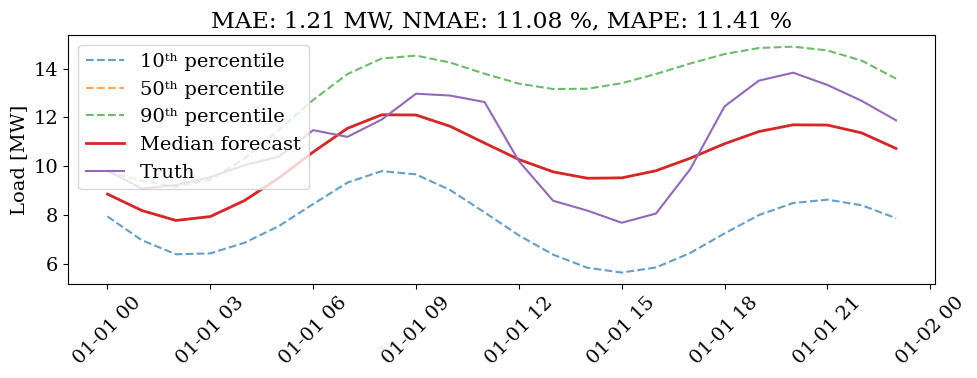

In [83]:
model.load_state_dict(torch.load(CFG['save_name']))
mae,mape,mean=evaluate(te_ld,sy,model)
print(f'TEST MAE {mae:.2f} MW | NMAE {mae/mean*100:.2f}% | MAPE {mape:.2f}%')

plot_quantile_forecast(0, te_ld, model, sy, quantiles=[0.1,0.5,0.9])

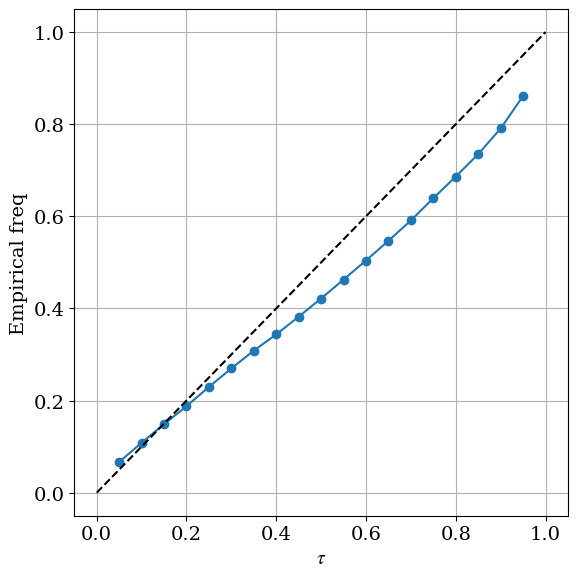

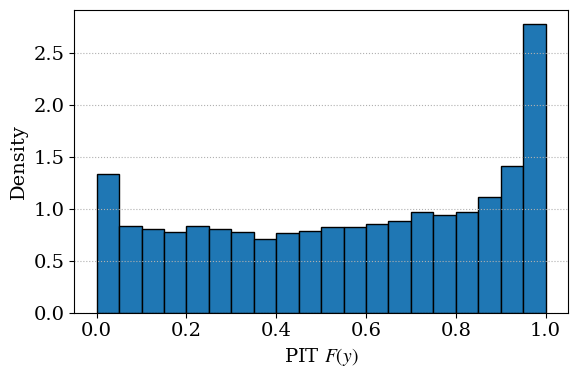

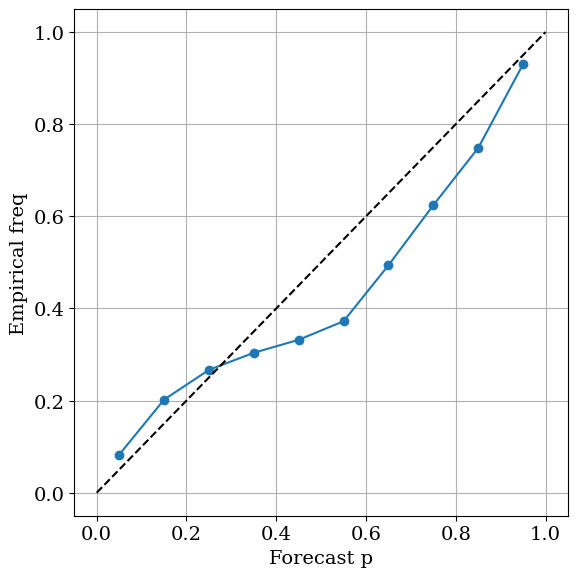

PIT mean (ideal 0.5):                0.561
Mean central 50 % interval width:    1.574
Expected Calibration Error (ECE):    0.07119
Brier reliability component:         0.00649
Mean CRPS (Gaussian):               13.310


In [75]:


# ────────────────────────────────────────────
# Probabilistic metric evaluation
# ────────────────────────────────────────────
# ── uantile output head (10 %, 50 %, 90 %)
mus, sigs, ys = gather_predictions(model, te_ld, device, sy,
                                   head_type="quantile", q_index=(0, 1, 2))

taus, obs_fr = reliability_curve(mus, sigs, ys)
pit_vals     = norm.cdf((ys - mus) / sigs)

θ            = np.median(ys)
p_event      = norm.cdf((θ - mus) / sigs)
o_event      = (ys <= θ).astype(int)

ece   = expected_calibration_error(p_event, o_event)
rel_c = brier_reliability_component(p_event, o_event)
pit_m = pit_vals.mean()
width = central_interval_width(mus, sigs)

try:
    from properscoring import crps_gaussian
    crps = crps_gaussian(ys, mus, sigs).mean()
except ImportError:
    crps = np.nan
    print("properscoring not installed → CRPS skipped")

# ── Plots (unchanged except for density=True in PIT) ──
plt.rcParams.update({"mathtext.fontset":"stix",
                        "font.family":"serif","font.size":14})

# Reliability diagram
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(taus, obs_fr, 'o-'); ax.plot([0,1],[0,1],'k--')
ax.set(xlabel=r'$\tau$', ylabel='Empirical freq'); ax.grid(':')
plt.tight_layout(); plt.show()

# PIT histogram
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(pit_vals, bins=20, range=(0,1), density=True, edgecolor='black')
ax.set(xlabel='PIT $F(y)$', ylabel='Density'); ax.grid(axis='y', linestyle=':')
plt.tight_layout(); plt.show()

# Brier reliability curve
edges  = np.linspace(0,1,11); centres = 0.5*(edges[:-1]+edges[1:])
idx    = np.digitize(p_event, edges, right=True)-1
obs_b  = [o_event[idx==k].mean() if (idx==k).any() else np.nan for k in range(10)]
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(centres, obs_b, 'o-'); ax.plot([0,1],[0,1],'k--')
ax.set(xlabel='Forecast p', ylabel='Empirical freq'); ax.grid(':')
plt.tight_layout(); plt.show()

# Console summary
print(f"PIT mean (ideal 0.5):                {pit_m:.3f}")
print(f"Mean central 50 % interval width:    {width:.3f}")
print(f"Expected Calibration Error (ECE):    {ece:.5f}")
print(f"Brier reliability component:         {rel_c:.5f}")
if np.isfinite(crps):
    print(f"Mean CRPS (Gaussian):               {crps:.3f}")
